In [1]:
import os, sys
import pandas as pd
import numpy as np
import torch
import torch.optim as optim

from torch.utils.data import DataLoader

In [2]:
sys.path.append('../src')
from data.dataset import GWDataset, GWGridDataset, Normalize
from model.handler import ModelHandler

In [3]:
base_data_dir = '/srv/scratch/z5370003/projects/data/groundwater/FEFLOW/coastal/variable_density/'
interpolated_data_dir = os.path.join(base_data_dir, 'interpolated')

In [4]:
_mean = np.array([3.29223762e-01])
_std = np.array([2.17284490e-01])
input_transform = Normalize(mean=_mean, std=_std)
output_transform = Normalize(mean=_mean, std=_std)

In [5]:
in_window_size = 5
out_window_size = 5
val_ratio = 0.3

batch_size = 32

train_ds = GWGridDataset(data_path=interpolated_data_dir,
                         dataset='train', val_ratio=val_ratio,
                         in_window_size=in_window_size,
                         out_window_size=out_window_size,
                         input_transform=input_transform,
                         output_transform=output_transform)

train_dl = DataLoader(train_ds, batch_size=batch_size, 
                      shuffle=True, pin_memory=True)

len(train_dl)

42

In [6]:
val_ds = GWGridDataset(data_path=interpolated_data_dir,
                         dataset='val', val_ratio=val_ratio,
                         in_window_size=in_window_size,
                         out_window_size=out_window_size,
                         input_transform=input_transform,
                         output_transform=output_transform)

val_dl = DataLoader(val_ds, batch_size=batch_size, 
                      shuffle=False, pin_memory=True)

len(val_dl)

18

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda')

In [9]:
from model.neuralop.fno import FNO
from model.neuralop.losses import LpLoss, H1Loss

In [10]:
# Losses
l2loss = LpLoss(d=3, p=2)
h1loss = H1Loss(d=3)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

# Model configuration
n_modes = (8, 8, 8)
in_channels = in_window_size
out_channels = out_window_size
hidden_channels = 32
projection_channels = 64


model = FNO(n_modes=n_modes, in_channels=in_channels, 
            out_channels=out_channels,
            hidden_channels=hidden_channels, 
            projection_channels=projection_channels).double()


model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),
                            lr=1e-2,
                            weight_decay=1e-4)


scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

In [11]:
model_handler = ModelHandler(model=model, device=device, optimizer=optimizer, criterion=h1loss, scheduler=scheduler)

In [12]:
model_handler.train(train_dl, num_epochs=2)

100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Epoch [1/2], Loss: 43.1356


100%|██████████| 42/42 [00:23<00:00,  1.80it/s]

Epoch [2/2], Loss: 15.2303


In [13]:
print(f"Train loss: {model_handler.evaluate(train_dl)}")
# print(f"Test loss: {model_handler.evaluate(test_dl)}")

Train loss: 15.99846641298578


In [14]:
import matplotlib.pyplot as plt

def plot_2d_projection(x_grid, y_grid, z_grid, values):

    # Create a figure with 3 subplots for different slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    vmin = np.nanmin(values)
    vmax = np.nanmax(values)
    
    # Plot slices through the middle of each dimension
    middle_x = values.shape[0]//2
    middle_y = values.shape[1]//2 
    middle_z = values.shape[2]//2
    
    # YZ plane (constant X)
    for ix in range(values.shape[0]):
        im1 = ax1.imshow(values[ix,:,:].T, aspect='auto', 
                        extent=[y_grid[0], y_grid[-1], z_grid[0], z_grid[-1]],
                        origin='lower', cmap='viridis', alpha=0.1, vmin=vmin, vmax=vmax)
    ax1.set_title('YZ plane (constant X)')
    ax1.set_xlabel('Y')
    ax1.set_ylabel('Z')
    plt.colorbar(im1, ax=ax1)
    
    # XZ plane (constant Y)
    for iy in range(values.shape[1]):
        im2 = ax2.imshow(values[:,iy,:].T, aspect='auto',
                        extent=[x_grid[0], x_grid[-1], z_grid[0], z_grid[-1]],
                        origin='lower', cmap='viridis', alpha=0.1, vmin=vmin, vmax=vmax)
    ax2.set_title('XZ plane (constant Y)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    plt.colorbar(im2, ax=ax2)
    
    # XY plane (constant Z)
    for iz in range(values.shape[2]):
        im3 = ax3.imshow(values[:,:,iz].T, aspect='auto',
                        extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
                        origin='lower', cmap='viridis', alpha=0.1, vmin=vmin, vmax=vmax)
    ax3.set_title('XY plane (constant Z)')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    plt.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()

    return fig


In [15]:
preds = np.array(model_handler.predict(val_dl))
preds = output_transform.inverse_transform(torch.tensor(preds))
preds

100%|██████████| 18/18 [00:03<00:00,  4.85it/s]


tensor([[[[[0.0983, 0.0993, 0.1003,  ..., 0.0955, 0.0964, 0.0973],
           [0.0989, 0.0997, 0.1007,  ..., 0.0965, 0.0973, 0.0981],
           [0.0993, 0.1000, 0.1008,  ..., 0.0972, 0.0980, 0.0987],
           ...,
           [0.0968, 0.0984, 0.0993,  ..., 0.0925, 0.0934, 0.0950],
           [0.0971, 0.0985, 0.0994,  ..., 0.0932, 0.0942, 0.0956],
           [0.0977, 0.0988, 0.0998,  ..., 0.0943, 0.0952, 0.0964]],

          [[0.0982, 0.0992, 0.1002,  ..., 0.0952, 0.0960, 0.0971],
           [0.0986, 0.0994, 0.1004,  ..., 0.0961, 0.0969, 0.0977],
           [0.0989, 0.0995, 0.1004,  ..., 0.0969, 0.0976, 0.0983],
           ...,
           [0.0966, 0.0984, 0.0996,  ..., 0.0925, 0.0934, 0.0948],
           [0.0970, 0.0985, 0.0997,  ..., 0.0932, 0.0940, 0.0954],
           [0.0976, 0.0989, 0.0999,  ..., 0.0941, 0.0950, 0.0962]],

          [[0.0979, 0.0990, 0.1000,  ..., 0.0951, 0.0959, 0.0968],
           [0.0982, 0.0991, 0.1000,  ..., 0.0959, 0.0966, 0.0974],
           [0.0984, 0.0991

In [16]:
targets = []
for batch, target in val_dl:
    targets.append(target.detach().numpy())


targets = np.concatenate(targets, axis=0)

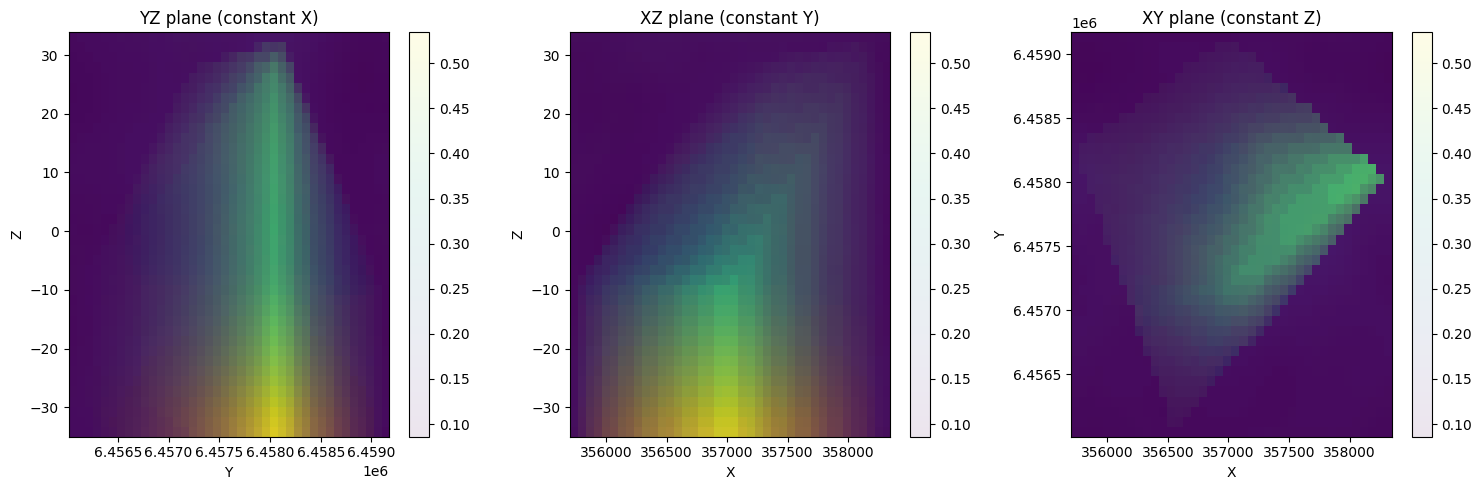

In [17]:
project_dir = '/srv/scratch/z5370003/projects/04_groundwater/variable_density/'
pred_fig = plot_2d_projection(val_ds.x_grid, val_ds.y_grid, val_ds.z_grid, preds[0, 0])
pred_fig.savefig(os.path.join(project_dir, 'results/FNO/prediction.png'), bbox_inches='tight')

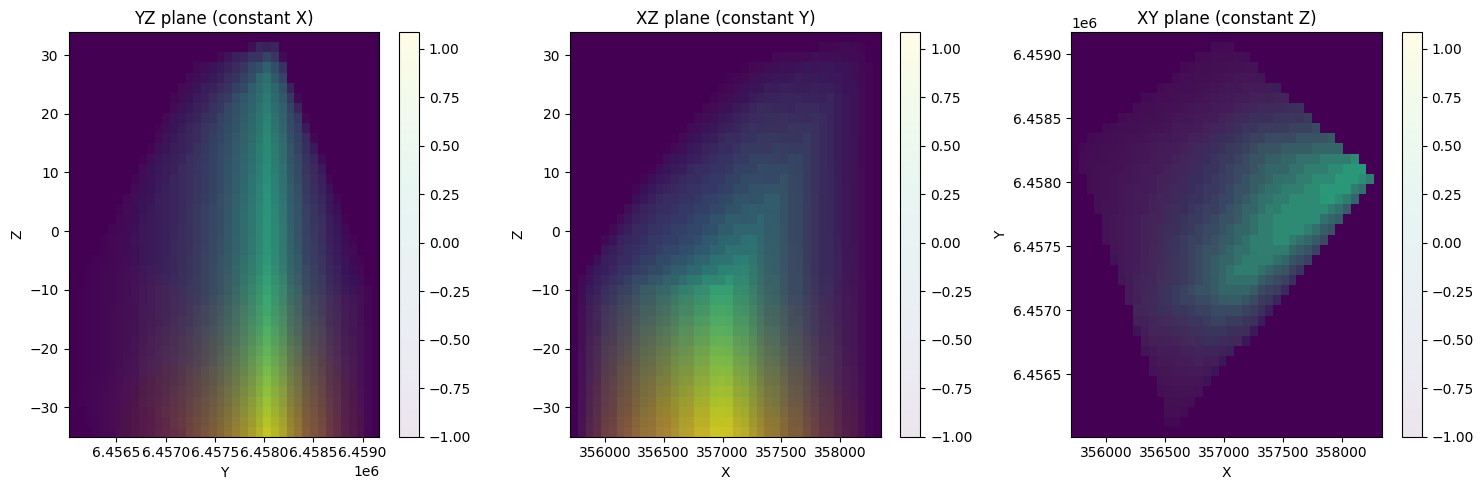

In [18]:
target_fig = plot_2d_projection(val_ds.x_grid, val_ds.y_grid, val_ds.z_grid, targets[0, 0])
target_fig.savefig(os.path.join(project_dir, 'results/FNO/target.png'), bbox_inches='tight')

In [41]:
torch.save(model.state_dict(), os.path.join(project_dir, 'results/FNO/savedmodel_fno'))

In [42]:
savedmodel = FNO(n_modes=n_modes, in_channels=in_channels, 
            out_channels=out_channels,
            hidden_channels=hidden_channels, 
            projection_channels=projection_channels).double()

In [43]:
for param in savedmodel.parameters():
    print(param)
    break

Parameter containing:
tensor([[[[[ 0.3162]]],


         [[[-0.3123]]],


         [[[-0.0481]]],


         [[[-0.0010]]],


         [[[ 0.1541]]]],



        [[[[ 0.2302]]],


         [[[-0.0958]]],


         [[[-0.3182]]],


         [[[ 0.2679]]],


         [[[ 0.2231]]]],



        [[[[ 0.4257]]],


         [[[ 0.2941]]],


         [[[ 0.3193]]],


         [[[ 0.2172]]],


         [[[ 0.2452]]]],



        ...,



        [[[[-0.3400]]],


         [[[ 0.2759]]],


         [[[ 0.0823]]],


         [[[ 0.1089]]],


         [[[ 0.3615]]]],



        [[[[ 0.4375]]],


         [[[-0.2799]]],


         [[[-0.1900]]],


         [[[ 0.3930]]],


         [[[-0.3332]]]],



        [[[[ 0.4443]]],


         [[[ 0.0343]]],


         [[[-0.1020]]],


         [[[-0.1269]]],


         [[[-0.0582]]]]], dtype=torch.float64, requires_grad=True)


In [44]:
savedmodel.load_state_dict(torch.load(os.path.join(project_dir, 'results/FNO/savedmodel_fno'), weights_only=True))

<All keys matched successfully>

In [45]:
for param in savedmodel.parameters():
    print(param)
    break

Parameter containing:
tensor([[[[[ 0.2481]]],


         [[[-0.1725]]],


         [[[ 0.1690]]],


         [[[-0.1203]]],


         [[[-0.1703]]]],



        [[[[-0.3019]]],


         [[[ 0.3395]]],


         [[[ 0.3626]]],


         [[[-0.3010]]],


         [[[-0.3471]]]],



        [[[[ 0.1620]]],


         [[[ 0.3856]]],


         [[[ 0.1245]]],


         [[[ 0.4507]]],


         [[[-0.2557]]]],



        ...,



        [[[[-0.1690]]],


         [[[ 0.2394]]],


         [[[-0.4550]]],


         [[[ 0.1989]]],


         [[[ 0.3398]]]],



        [[[[ 0.4345]]],


         [[[ 0.0304]]],


         [[[-0.2520]]],


         [[[-0.4368]]],


         [[[ 0.4036]]]],



        [[[[ 0.1835]]],


         [[[-0.2086]]],


         [[[ 0.0234]]],


         [[[ 0.4560]]],


         [[[-0.4213]]]]], dtype=torch.float64, requires_grad=True)
